In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# make 1000 samples
n_samples = 1000

# create circles
X_, y_ = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

print(f'Preview of X:\n{X_[:5]}\n')
print(f'Preview of y:\n{y_[:5]}')
# note that two samples within X correlates to one sample within y

Preview of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

Preview of y:
[1 1 1 1 0]


In [3]:
# make datafram of circle data
circles = pd.DataFrame({"x1": X_[:, 0],
                        "x2": X_[:, 1],
                        "label": y_})
circles

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


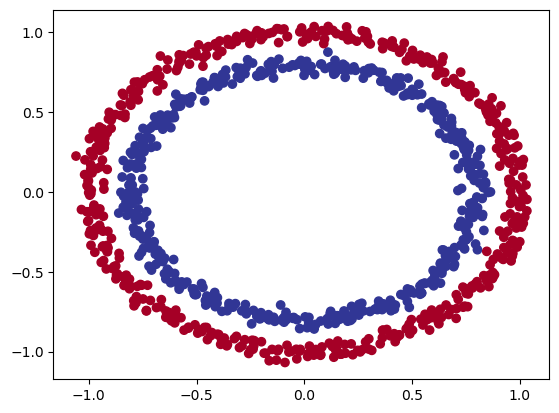

In [4]:
# visualize!
plt.scatter(x=X_[:, 0], y=X_[:, 1], c=y_, cmap=plt.cm.RdYlBu)

In [5]:
# turn data into tensors and create train / test splits
X = torch.from_numpy(X_).type(torch.float)
y = torch.from_numpy(y_).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test, 80% will be train
                                                    random_state=42) # similar to torch.manual_seed()

In [6]:
X_train.shape

torch.Size([800, 2])

In [7]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create the model
class CircleModelV0(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # takes 2 inputs, as per X_train.shape
        # each input for X has two components, thus we need two nodes
        # the two inputs are upscaled to 5 features
        self.layer_1 = nn.Linear(in_features=2, out_features=5) 
        
        # the in_features of the following layer must match the out_features of the previous
        # output 1 feature as per binary classification
        # the 1 feature is also reflective of the shape of y 
        self.layer_2 = nn.Linear(in_features=5, out_features=1) 
    
    def forward(self, x):
        # x -> layer 1 -> layer 2 -> return output
        return self.layer_2(self.layer_1(x))
        
# instantiate model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
# this is fine but we can replicate the model about using nn.Sequential()
# it is still important to understand how to subclass nn.Module since you may need to use it to modify certain areas
# alternatively again, you can instantiate nn.Sequential as an instance variable within a subclass of nn.Module
    # and define the reutrn of forward() as:
    # return self.NAME_OF_nn.Sequential_VARIABLE(x)
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1840, -0.4558],
                      [-0.3373,  0.0038],
                      [-0.1668,  0.0065],
                      [-0.3444, -0.5891],
                      [ 0.6795, -0.6669]])),
             ('0.bias', tensor([ 0.0697,  0.2305, -0.4385, -0.0039,  0.0380])),
             ('1.weight', tensor([[0.0300, 0.1233, 0.1862, 0.2011, 0.2835]])),
             ('1.bias', tensor([-0.0810]))])

In [10]:
# loss function + optimizer
loss_fn = nn.BCEWithLogitsLoss() # built in sigmoid activation
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [11]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [12]:
# the raw outputs of our model are called logits
# GOAL: raw logit -> prediction probability -> predicion label
# use sigmoid for binary classification and softmax for multiclass classification

with torch.inference_mode():
    y_logits = model_0(X_test)[:5] # raw logit

y_pred_probs = torch.sigmoid(y_logits) # prediction probabiltiy

y_preds = torch.round(y_pred_probs).squeeze() # prediction label (remove extra dimension)

y_preds, y_test[:5]

# its wrong since we havent actually trained anything but we're on the right track
# note the decision boundary is set 50/50

# in conclusion:
# RAW LOGIT: run test values through model
# PREDICTION PROB: apply sigmoid / some activation function
# PREDICTION LABEL: evaluate at the decision boundary for binary classification

(tensor([0., 0., 0., 0., 1.]), tensor([1., 0., 1., 0., 1.]))

In [13]:
# building a training and testing loop

torch.manual_seed(0)

epochs = 100

# put data to target device, in this case theres only one option (cpu) but in case there is more:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
 
for epoch in range(epochs):
    
    model_0.train()
    
    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # loss / accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() expects logit inputs 
                   y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
                      
    # optimizer
    optimizer.zero_grad()
                      
    # backprop
    loss.backward()
                      
    # gradient decsent
    optimizer.step()
    
#####################################################################################################################
    
    model_0.eval()
    
    with torch.inference_mode():
        
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 10 == 0:
        if epoch == 0:
            print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")
        else:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")

Epoch: 0  | Loss: 0.70182, Acc: 47.75 | Test Loss: 0.69453, | Test Acc: 49.50
Epoch: 10 | Loss: 0.69952, Acc: 47.75 | Test Loss: 0.69298, | Test Acc: 49.00
Epoch: 20 | Loss: 0.69797, Acc: 47.88 | Test Loss: 0.69212, | Test Acc: 51.00
Epoch: 30 | Loss: 0.69688, Acc: 48.00 | Test Loss: 0.69165, | Test Acc: 51.00
Epoch: 40 | Loss: 0.69608, Acc: 48.62 | Test Loss: 0.69141, | Test Acc: 51.50
Epoch: 50 | Loss: 0.69549, Acc: 48.62 | Test Loss: 0.69132, | Test Acc: 50.00
Epoch: 60 | Loss: 0.69503, Acc: 48.25 | Test Loss: 0.69131, | Test Acc: 50.50
Epoch: 70 | Loss: 0.69467, Acc: 48.12 | Test Loss: 0.69137, | Test Acc: 52.50
Epoch: 80 | Loss: 0.69438, Acc: 48.50 | Test Loss: 0.69146, | Test Acc: 52.50
Epoch: 90 | Loss: 0.69416, Acc: 48.62 | Test Loss: 0.69157, | Test Acc: 53.00


helper_functions.py already exists, skipping download


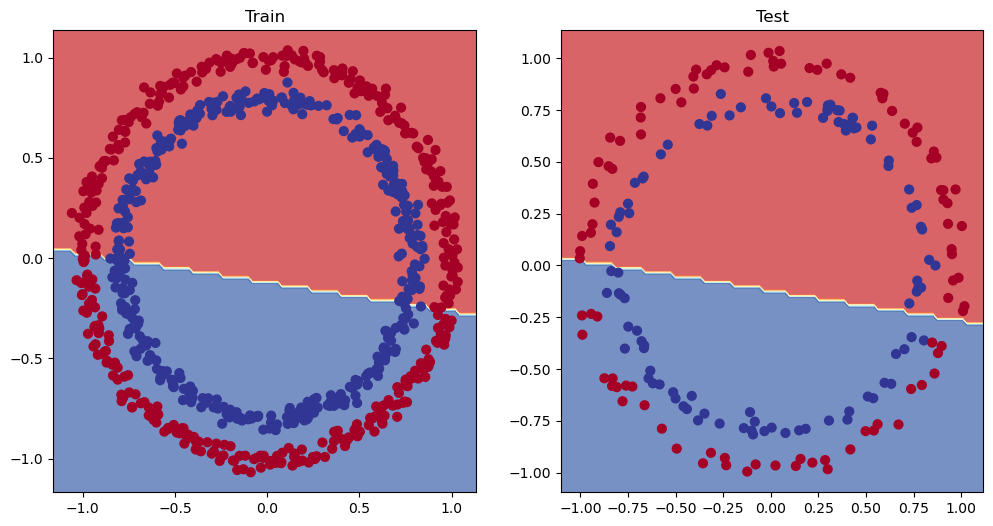

In [14]:
# the model isn't learning, to find out why, we can plot the decision boundary

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Epoch: 0    | Loss: 0.73028, Acc: 50.00 | Test Loss: 0.69168, | Test Acc: 50.00
Epoch: 100  | Loss: 0.69353, Acc: 49.62 | Test Loss: 0.69168, | Test Acc: 51.00
Epoch: 200  | Loss: 0.69304, Acc: 50.88 | Test Loss: 0.69168, | Test Acc: 45.50
Epoch: 300  | Loss: 0.69299, Acc: 50.88 | Test Loss: 0.69168, | Test Acc: 46.50
Epoch: 400  | Loss: 0.69298, Acc: 51.50 | Test Loss: 0.69168, | Test Acc: 46.00
Epoch: 500  | Loss: 0.69298, Acc: 51.62 | Test Loss: 0.69168, | Test Acc: 45.00
Epoch: 600  | Loss: 0.69298, Acc: 51.25 | Test Loss: 0.69168, | Test Acc: 45.00
Epoch: 700  | Loss: 0.69298, Acc: 51.12 | Test Loss: 0.69168, | Test Acc: 45.50
Epoch: 800  | Loss: 0.69298, Acc: 51.12 | Test Loss: 0.69168, | Test Acc: 46.00
Epoch: 900  | Loss: 0.69298, Acc: 51.12 | Test Loss: 0.69168, | Test Acc: 46.00
Epoch: 1000 | Loss: 0.69298, Acc: 51.00 | Test Loss: 0.69168, | Test Acc: 46.00


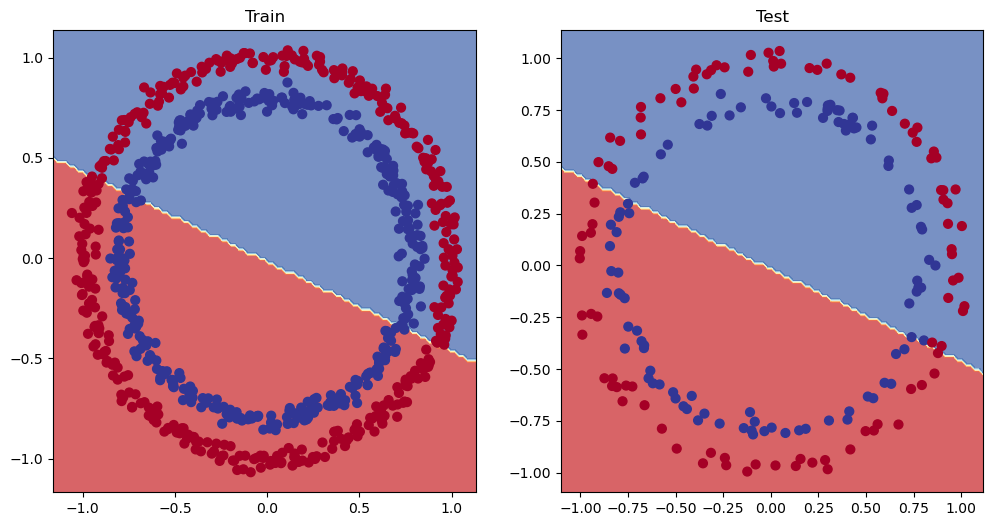

In [15]:
# we can try improving our model by implementing the following
# 1. adding more hidden units 5 -> 10
# 2. adding more layers 2 -> 3
# 3. increasing epoch count 100 -> 1000

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1()

# create loss function + optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs + 1):
    
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        tess_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
    if epoch % 100 == 0:
        if epoch == 0:
            print(f"Epoch: {epoch}    | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")
        elif epoch == 1000:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")
        else:
            print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Epoch: 0 | Loss: 0.52008 | Test Loss: 0.78884
Epoch: 500 | Loss: 0.02530 | Test Loss: 0.00498
Epoch: 1000 | Loss: 0.02134 | Test Loss: 0.00488
Epoch: 1500 | Loss: 0.02112 | Test Loss: 0.00429
Epoch: 2000 | Loss: 0.01958 | Test Loss: 0.00397
Epoch: 2500 | Loss: 0.01749 | Test Loss: 0.00324
Epoch: 3000 | Loss: 0.01744 | Test Loss: 0.00339
Epoch: 3500 | Loss: 0.01648 | Test Loss: 0.00307
Epoch: 4000 | Loss: 0.01518 | Test Loss: 0.00288
Epoch: 4500 | Loss: 0.01414 | Test Loss: 0.00234
Epoch: 5000 | Loss: 0.01475 | Test Loss: 0.00263


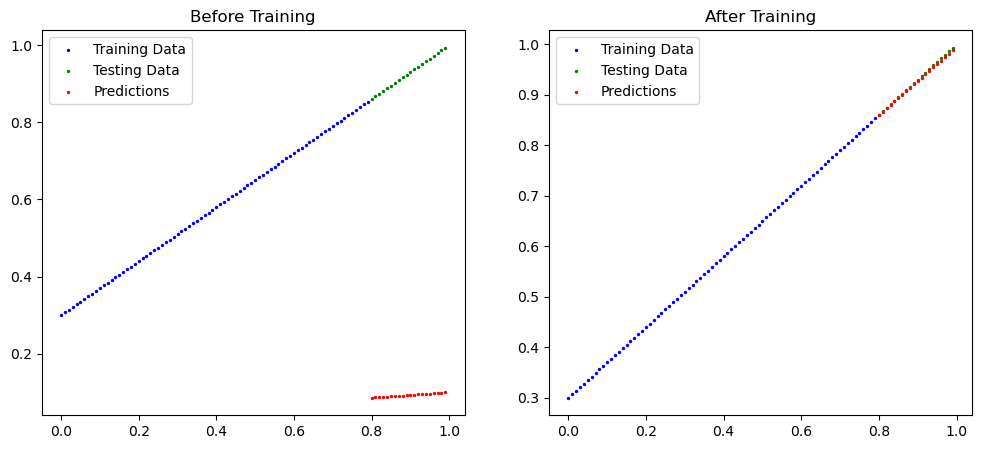

In [16]:
# try testing the model on a straight line dataset

weight = 0.7
bias = 0.3

torch.manual_seed(0)
X = torch.arange(0, 1, 0.01).unsqueeze(1)
y = weight * X + bias

split = int(0.8 * len(X))

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model_2 = nn.Sequential(
    nn.Linear(1, 10),

    nn.Linear(10, 10),

    nn.Linear(10, 1)
).to(device)

epochs = 5000

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

with torch.inference_mode():
    untrained_preds = model_2(X_test)

for epoch in range(epochs + 1):
    model_2.train()
    y_preds = model_2(X_train)
    loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test)
        test_loss = loss_fn(test_preds, y_test)
    
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

with torch.inference_mode():
    trained_preds = model_2(X_test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Before Training')
plt.scatter(X_train, y_train, c='b', s=2, label='Training Data')
plt.scatter(X_test, y_test, c='g', s=2, label='Testing Data')
plt.scatter(X_test, untrained_preds, c='r', s=2, label='Predictions')
plt.legend()
plt.subplot(1,2,2)
plt.title('After Training')
plt.scatter(X_train, y_train, c='b', s=2, label='Training Data')
plt.scatter(X_test, y_test, c='g', s=2, label='Testing Data')
plt.scatter(X_test, trained_preds, c='r', s=2, label='Predictions')
plt.legend()

Epoch: 0 | Loss: 0.69309, Acc: 50.00 | Test Loss: 0.00263, | Test Acc: 50.00
Epoch: 300 | Loss: 0.68048, Acc: 60.38 | Test Loss: 0.00263, | Test Acc: 53.00
Epoch: 600 | Loss: 0.63507, Acc: 71.62 | Test Loss: 0.00263, | Test Acc: 64.00
Epoch: 900 | Loss: 0.36488, Acc: 99.12 | Test Loss: 0.00263, | Test Acc: 96.50
Epoch: 1200 | Loss: 0.08307, Acc: 99.88 | Test Loss: 0.00263, | Test Acc: 100.00
Epoch: 1500 | Loss: 0.03223, Acc: 100.00 | Test Loss: 0.00263, | Test Acc: 100.00


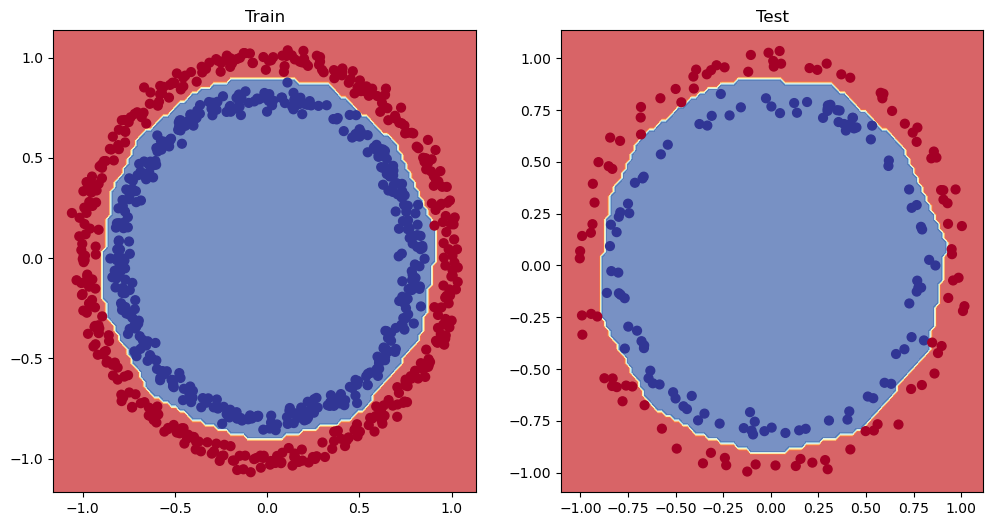

In [17]:
# we've proven the model has the capacity to learn, meaning the issue lies elsewhere
# note the cirle data is non-linear, thus we must use non-linear layers when constructing the model

# re-instantiate the circle data
X_, y_ = make_circles(n_samples, noise=0.03, random_state=42)
X = torch.from_numpy(X_).type(torch.float)
y = torch.from_numpy(y_).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

epochs = 1500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs + 1):
    
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        tess_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
    if epoch % 300 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} \
| Test Loss: {test_loss:.5f}, | Test Acc: {test_acc:.2f}")

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Putting it together with a multi-class problem

Epoch: 0 | Loss: 0.8937 | Acc: 68.12 | Test Loss: 0.5907 | Test Acc: 78.00
Epoch: 10 | Loss: 0.1676 | Acc: 99.25 | Test Loss: 0.1475 | Test Acc: 99.50
Epoch: 20 | Loss: 0.0875 | Acc: 99.12 | Test Loss: 0.0778 | Test Acc: 99.50
Epoch: 30 | Loss: 0.0626 | Acc: 99.12 | Test Loss: 0.0542 | Test Acc: 99.50
Epoch: 40 | Loss: 0.0509 | Acc: 99.12 | Test Loss: 0.0427 | Test Acc: 99.50
Epoch: 50 | Loss: 0.0443 | Acc: 99.12 | Test Loss: 0.0360 | Test Acc: 99.50
Epoch: 60 | Loss: 0.0401 | Acc: 99.12 | Test Loss: 0.0317 | Test Acc: 99.50
Epoch: 70 | Loss: 0.0372 | Acc: 99.12 | Test Loss: 0.0287 | Test Acc: 99.50
Epoch: 80 | Loss: 0.0351 | Acc: 99.12 | Test Loss: 0.0264 | Test Acc: 99.50
Epoch: 90 | Loss: 0.0335 | Acc: 99.12 | Test Loss: 0.0247 | Test Acc: 99.50
Epoch: 100 | Loss: 0.0323 | Acc: 99.12 | Test Loss: 0.0233 | Test Acc: 99.50


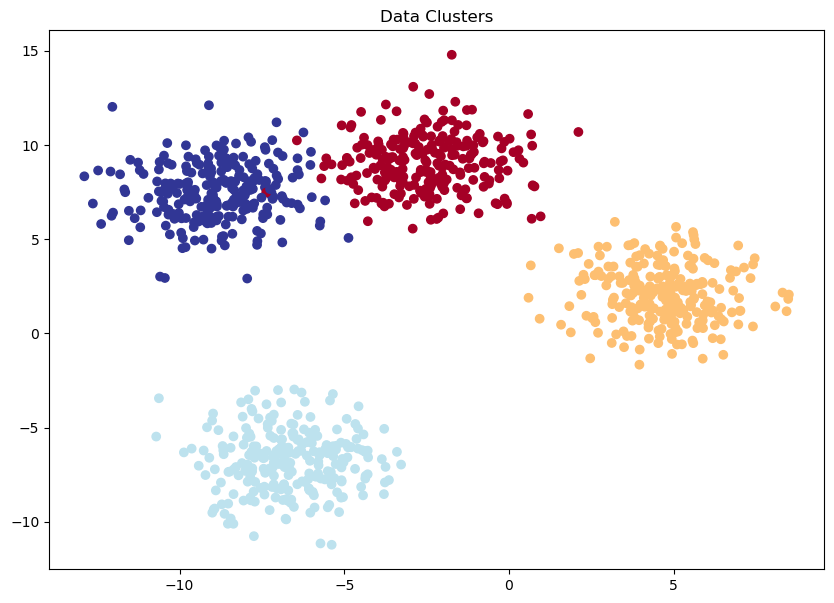

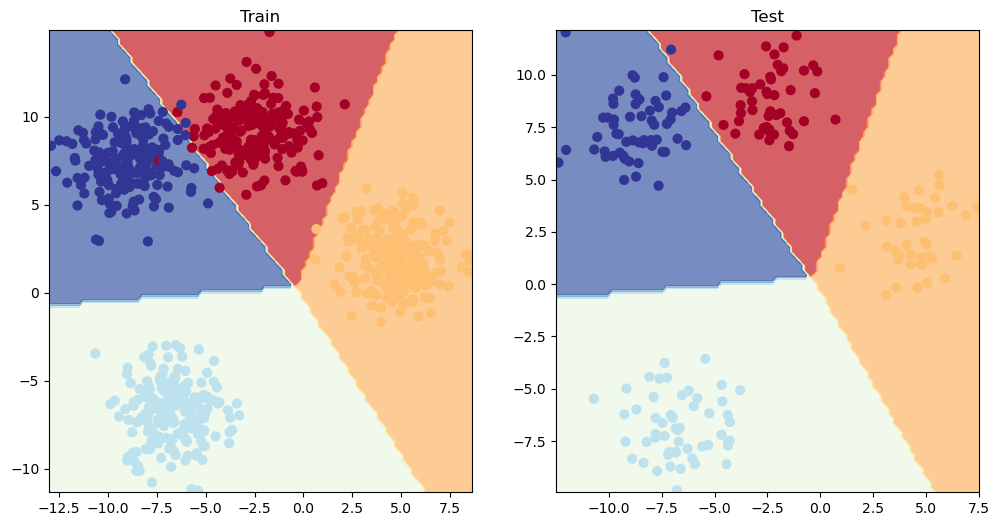

In [18]:
from sklearn.datasets import make_blobs

# hyperparams (check documentation for make_blobs)
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42 # arbitrary 

# data creation (remember X: features, y: labels)
X_blob, y_blob = make_blobs(n_samples=1000,
                              n_features=NUM_FEATURES,
                              centers=NUM_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = \
train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# test data with a plot
plt.figure(figsize=(10,7))
plt.title('Data Clusters')
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance
torch.manual_seed(0)
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
# note that the input features aligns with the shape of X_blob and the output features aligns with the number of
# classes in y_blob

# loss function & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

# test with current untrained outputs
model_4.eval()
with torch.inference_mode():
    y_logits_untrained = model_4(X_blob_train.to(device))         # raw output
y_pred_probs_untrained = torch.softmax(y_logits_untrained, dim=1) # prediction probabi
y_preds_untrained = torch.argmax(y_pred_probs_untrained, dim=1)   # argmax

# create a training and testing loop
epochs = 100

for epoch in range(epochs + 1):
    
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train.type(torch.long))
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test.type(torch.long))
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | \
Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

# making predictions and evaluating
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred = torch.argmax(y_pred_probs, dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [19]:
model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.0262,  0.5001],
                      [-0.6999, -0.5582],
                      [-0.6281,  0.3177],
                      [-0.0140,  0.7799],
                      [ 0.1575,  0.2873],
                      [-0.0894, -0.1216],
                      [-1.0293, -0.5823],
                      [-0.5162,  0.0436]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.2723,  0.4061, -0.5470, -0.3485,  0.2723,  0.6073, -0.1871,  0.5044])),
             ('linear_layer_stack.1.weight',
              tensor([[ 0.0327,  0.1392,  0.6039, -0.1354, -0.1962, -0.0862,  0.1030,  0.4565],
                      [-0.2934,  0.0218, -0.2239, -0.4357, -0.2453,  0.3567,  0.3670,  0.2341],
                      [-0.0711,  0.0867,  0.1141, -0.4687, -0.3145, -0.1117,  0.5380,  0.3041],
                      [-0.1085,  0.0432,  0.4096,  0.4695,  0.1462,  0.0380,  0.3895, -0.1207],
                      [ 0.1248, -0.4347, -0.317